In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
# import transformers
# nltk.download('punkt')
# nltk.download('stopwords')
stop = stopwords.words('english')
import re
from sklearn import feature_extraction, model_selection, naive_bayes, pipeline, manifold, preprocessing, metrics
from lime import lime_text
import gensim
import gensim.downloader as gensim_api
from tensorflow.keras import models, layers, preprocessing as kprocessing
from tensorflow.keras import backend as K

In [2]:
all_wines = pd.read_csv('Data/winemag-data-130k-v2.csv')
all_wines.head()

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


In [3]:
clean_wines = all_wines.drop(columns=['Unnamed: 0', 'taster_twitter_handle', 'region_2'])
clean_wines = clean_wines.dropna()
clean_wines.head()

,country,description,designation,points,price,province,region_1,taster_name,title,variety,winery
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,Alexander Peartree,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Paul Gregutt,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks
5,Spain,Blackberry and raspberry aromas show a typical...,Ars In Vitro,87,15.0,Northern Spain,Navarra,Michael Schachner,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,Tempranillo-Merlot,Tandem
6,Italy,"Here's a bright, informal red that opens with ...",Belsito,87,16.0,Sicily & Sardinia,Vittoria,Kerin O’Keefe,Terre di Giurfo 2013 Belsito Frappato (Vittoria),Frappato,Terre di Giurfo
9,France,This has great depth of flavor with its fresh ...,Les Natures,87,27.0,Alsace,Alsace,Roger Voss,Jean-Baptiste Adam 2012 Les Natures Pinot Gris...,Pinot Gris,Jean-Baptiste Adam


In [4]:
clean_wines['variety'] = clean_wines['variety'].replace(['Weissburgunder'], 'Chardonnay')
clean_wines['variety'] = clean_wines['variety'].replace(['Spatburgunder'], 'Pinot Noir')
clean_wines['variety'] = clean_wines['variety'].replace(['Grauburgunder'], 'Pinot Gris')
clean_wines['variety'] = clean_wines['variety'].replace(['Garnacha'], 'Grenache')
clean_wines['variety'] = clean_wines['variety'].replace(['Pinot Nero'], 'Pinot Noir')
clean_wines['variety'] = clean_wines['variety'].replace(['Alvarinho'], 'Albarino')

In [5]:
clean_wines['vintage'] = clean_wines['title'].str.extract('(\d\d\d\d)', expand=True)
clean_wines

,country,description,designation,points,price,province,region_1,taster_name,title,variety,winery,vintage
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,Alexander Peartree,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian,2013
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Paul Gregutt,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks,2012
5,Spain,Blackberry and raspberry aromas show a typical...,Ars In Vitro,87,15.0,Northern Spain,Navarra,Michael Schachner,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,Tempranillo-Merlot,Tandem,2011
6,Italy,"Here's a bright, informal red that opens with ...",Belsito,87,16.0,Sicily & Sardinia,Vittoria,Kerin O’Keefe,Terre di Giurfo 2013 Belsito Frappato (Vittoria),Frappato,Terre di Giurfo,2013
9,France,This has great depth of flavor with its fresh ...,Les Natures,87,27.0,Alsace,Alsace,Roger Voss,Jean-Baptiste Adam 2012 Les Natures Pinot Gris...,Pinot Gris,Jean-Baptiste Adam,2012
...,...,...,...,...,...,...,...,...,...,...,...,...
129959,France,The granite soil of the Brand Grand Cru vineya...,Brand Grand Cru,90,57.0,Alsace,Alsace,Roger Voss,Cave de Turckheim 2010 Brand Grand Cru Pinot G...,Pinot Gris,Cave de Turckheim,2010
129962,Italy,"Blackberry, cassis, grilled herb and toasted a...",Sàgana Tenuta San Giacomo,90,40.0,Sicily & Sardinia,Sicilia,Kerin O’Keefe,Cusumano 2012 Sàgana Tenuta San Giacomo Nero d...,Nero d'Avola,Cusumano,2012
129965,France,"While it's rich, this beautiful dry wine also ...",Seppi Landmann Vallée Noble,90,28.0,Alsace,Alsace,Roger Voss,Domaine Rieflé-Landmann 2013 Seppi Landmann Va...,Pinot Gris,Domaine Rieflé-Landmann,2013
129968,France,Well-drained gravel soil gives this wine its c...,Kritt,90,30.0,Alsace,Alsace,Roger Voss,Domaine Gresser 2013 Kritt Gewurztraminer (Als...,Gewürztraminer,Domaine Gresser,2013


In [6]:
clean_wines['type'] = ['white' if x in ['Chardonnay', 'Riesling', 'Sauvignon Blanc', 'White Blend', 'Sparkling Blend', 'Pinot Gris',
                                        'Champagne Blend', 'GrÃ¼ner Veltliner', 'Pinot Grigio', 'Portuguese White', 'Viognier',
                                        'GewÃ¼rztraminer', 'GewÃ¼rztraminer'] else 'red' for x in clean_wines['variety']]
clean_wines


,country,description,designation,points,price,province,region_1,taster_name,title,variety,winery,vintage,type
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,Alexander Peartree,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian,2013,white
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Paul Gregutt,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks,2012,red
5,Spain,Blackberry and raspberry aromas show a typical...,Ars In Vitro,87,15.0,Northern Spain,Navarra,Michael Schachner,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,Tempranillo-Merlot,Tandem,2011,red
6,Italy,"Here's a bright, informal red that opens with ...",Belsito,87,16.0,Sicily & Sardinia,Vittoria,Kerin O’Keefe,Terre di Giurfo 2013 Belsito Frappato (Vittoria),Frappato,Terre di Giurfo,2013,red
9,France,This has great depth of flavor with its fresh ...,Les Natures,87,27.0,Alsace,Alsace,Roger Voss,Jean-Baptiste Adam 2012 Les Natures Pinot Gris...,Pinot Gris,Jean-Baptiste Adam,2012,white
...,...,...,...,...,...,...,...,...,...,...,...,...,...
129959,France,The granite soil of the Brand Grand Cru vineya...,Brand Grand Cru,90,57.0,Alsace,Alsace,Roger Voss,Cave de Turckheim 2010 Brand Grand Cru Pinot G...,Pinot Gris,Cave de Turckheim,2010,white
129962,Italy,"Blackberry, cassis, grilled herb and toasted a...",Sàgana Tenuta San Giacomo,90,40.0,Sicily & Sardinia,Sicilia,Kerin O’Keefe,Cusumano 2012 Sàgana Tenuta San Giacomo Nero d...,Nero d'Avola,Cusumano,2012,red
129965,France,"While it's rich, this beautiful dry wine also ...",Seppi Landmann Vallée Noble,90,28.0,Alsace,Alsace,Roger Voss,Domaine Rieflé-Landmann 2013 Seppi Landmann Va...,Pinot Gris,Domaine Rieflé-Landmann,2013,white
129968,France,Well-drained gravel soil gives this wine its c...,Kritt,90,30.0,Alsace,Alsace,Roger Voss,Domaine Gresser 2013 Kritt Gewurztraminer (Als...,Gewürztraminer,Domaine Gresser,2013,red


In [7]:
clean_wines['word_count'] = clean_wines['description'].str.lower().str.split().str.len()
clean_wines

,country,description,designation,points,price,province,region_1,taster_name,title,variety,winery,vintage,type,word_count
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,Alexander Peartree,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian,2013,white,33
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Paul Gregutt,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks,2012,red,41
5,Spain,Blackberry and raspberry aromas show a typical...,Ars In Vitro,87,15.0,Northern Spain,Navarra,Michael Schachner,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,Tempranillo-Merlot,Tandem,2011,red,42
6,Italy,"Here's a bright, informal red that opens with ...",Belsito,87,16.0,Sicily & Sardinia,Vittoria,Kerin O’Keefe,Terre di Giurfo 2013 Belsito Frappato (Vittoria),Frappato,Terre di Giurfo,2013,red,31
9,France,This has great depth of flavor with its fresh ...,Les Natures,87,27.0,Alsace,Alsace,Roger Voss,Jean-Baptiste Adam 2012 Les Natures Pinot Gris...,Pinot Gris,Jean-Baptiste Adam,2012,white,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129959,France,The granite soil of the Brand Grand Cru vineya...,Brand Grand Cru,90,57.0,Alsace,Alsace,Roger Voss,Cave de Turckheim 2010 Brand Grand Cru Pinot G...,Pinot Gris,Cave de Turckheim,2010,white,52
129962,Italy,"Blackberry, cassis, grilled herb and toasted a...",Sàgana Tenuta San Giacomo,90,40.0,Sicily & Sardinia,Sicilia,Kerin O’Keefe,Cusumano 2012 Sàgana Tenuta San Giacomo Nero d...,Nero d'Avola,Cusumano,2012,red,37
129965,France,"While it's rich, this beautiful dry wine also ...",Seppi Landmann Vallée Noble,90,28.0,Alsace,Alsace,Roger Voss,Domaine Rieflé-Landmann 2013 Seppi Landmann Va...,Pinot Gris,Domaine Rieflé-Landmann,2013,white,32
129968,France,Well-drained gravel soil gives this wine its c...,Kritt,90,30.0,Alsace,Alsace,Roger Voss,Domaine Gresser 2013 Kritt Gewurztraminer (Als...,Gewürztraminer,Domaine Gresser,2013,red,43


In [8]:
clean_wines = clean_wines[clean_wines['vintage'].notna()]
clean_wines = clean_wines.copy()
clean_wines['vintage'] = clean_wines['vintage'].astype(int)
clean_wines['age'] = 2020 - clean_wines['vintage'] 
clean_wines

,country,description,designation,points,price,province,region_1,taster_name,title,variety,winery,vintage,type,word_count,age
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,Alexander Peartree,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian,2013,white,33,7
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Paul Gregutt,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks,2012,red,41,8
5,Spain,Blackberry and raspberry aromas show a typical...,Ars In Vitro,87,15.0,Northern Spain,Navarra,Michael Schachner,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,Tempranillo-Merlot,Tandem,2011,red,42,9
6,Italy,"Here's a bright, informal red that opens with ...",Belsito,87,16.0,Sicily & Sardinia,Vittoria,Kerin O’Keefe,Terre di Giurfo 2013 Belsito Frappato (Vittoria),Frappato,Terre di Giurfo,2013,red,31,7
9,France,This has great depth of flavor with its fresh ...,Les Natures,87,27.0,Alsace,Alsace,Roger Voss,Jean-Baptiste Adam 2012 Les Natures Pinot Gris...,Pinot Gris,Jean-Baptiste Adam,2012,white,30,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129959,France,The granite soil of the Brand Grand Cru vineya...,Brand Grand Cru,90,57.0,Alsace,Alsace,Roger Voss,Cave de Turckheim 2010 Brand Grand Cru Pinot G...,Pinot Gris,Cave de Turckheim,2010,white,52,10
129962,Italy,"Blackberry, cassis, grilled herb and toasted a...",Sàgana Tenuta San Giacomo,90,40.0,Sicily & Sardinia,Sicilia,Kerin O’Keefe,Cusumano 2012 Sàgana Tenuta San Giacomo Nero d...,Nero d'Avola,Cusumano,2012,red,37,8
129965,France,"While it's rich, this beautiful dry wine also ...",Seppi Landmann Vallée Noble,90,28.0,Alsace,Alsace,Roger Voss,Domaine Rieflé-Landmann 2013 Seppi Landmann Va...,Pinot Gris,Domaine Rieflé-Landmann,2013,white,32,7
129968,France,Well-drained gravel soil gives this wine its c...,Kritt,90,30.0,Alsace,Alsace,Roger Voss,Domaine Gresser 2013 Kritt Gewurztraminer (Als...,Gewürztraminer,Domaine Gresser,2013,red,43,7


In [9]:
clean_wines = clean_wines.drop_duplicates('description')
clean_wines = clean_wines[pd.notnull(clean_wines.price)]

In [10]:
clean_wines.quantile(q=0.75, axis=0, numeric_only=True)

points          91.0
price           49.0
vintage       2014.0
word_count      49.0
age             10.0
Name: 0.75, dtype: float64

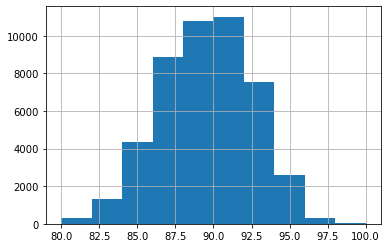

In [11]:
clean_wines['points'].hist()

In [12]:
clean_wines['good_meh'] = clean_wines['points'].apply(lambda x: 'good' if x >= 91 else 'meh')
clean_wines

,country,description,designation,points,price,province,region_1,taster_name,title,variety,winery,vintage,type,word_count,age,good_meh
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,Alexander Peartree,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian,2013,white,33,7,meh
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Paul Gregutt,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks,2012,red,41,8,meh
5,Spain,Blackberry and raspberry aromas show a typical...,Ars In Vitro,87,15.0,Northern Spain,Navarra,Michael Schachner,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,Tempranillo-Merlot,Tandem,2011,red,42,9,meh
6,Italy,"Here's a bright, informal red that opens with ...",Belsito,87,16.0,Sicily & Sardinia,Vittoria,Kerin O’Keefe,Terre di Giurfo 2013 Belsito Frappato (Vittoria),Frappato,Terre di Giurfo,2013,red,31,7,meh
9,France,This has great depth of flavor with its fresh ...,Les Natures,87,27.0,Alsace,Alsace,Roger Voss,Jean-Baptiste Adam 2012 Les Natures Pinot Gris...,Pinot Gris,Jean-Baptiste Adam,2012,white,30,8,meh
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129959,France,The granite soil of the Brand Grand Cru vineya...,Brand Grand Cru,90,57.0,Alsace,Alsace,Roger Voss,Cave de Turckheim 2010 Brand Grand Cru Pinot G...,Pinot Gris,Cave de Turckheim,2010,white,52,10,meh
129962,Italy,"Blackberry, cassis, grilled herb and toasted a...",Sàgana Tenuta San Giacomo,90,40.0,Sicily & Sardinia,Sicilia,Kerin O’Keefe,Cusumano 2012 Sàgana Tenuta San Giacomo Nero d...,Nero d'Avola,Cusumano,2012,red,37,8,meh
129965,France,"While it's rich, this beautiful dry wine also ...",Seppi Landmann Vallée Noble,90,28.0,Alsace,Alsace,Roger Voss,Domaine Rieflé-Landmann 2013 Seppi Landmann Va...,Pinot Gris,Domaine Rieflé-Landmann,2013,white,32,7,meh
129968,France,Well-drained gravel soil gives this wine its c...,Kritt,90,30.0,Alsace,Alsace,Roger Voss,Domaine Gresser 2013 Kritt Gewurztraminer (Als...,Gewürztraminer,Domaine Gresser,2013,red,43,7,meh


In [13]:
good_wines = clean_wines[clean_wines['good_meh'] == 'good']
good_wines

,country,description,designation,points,price,province,region_1,taster_name,title,variety,winery,vintage,type,word_count,age,good_meh
123,Australia,The blend is roughly two-thirds Shiraz and one...,Parson's Flat,92,40.0,South Australia,Padthaway,Joe Czerwinski,Henry's Drive Vignerons 2006 Parson's Flat Shi...,Shiraz-Cabernet Sauvignon,Henry's Drive Vignerons,2006,red,36,14,good
144,US,"Thick and brooding, this dark, sweetly tannic ...",K Block,91,85.0,California,Spring Mountain District,Virginie Boone,Terra Valentine 2013 K Block Cabernet Sauvigno...,Cabernet Sauvignon,Terra Valentine,2013,red,37,7,good
145,US,"Cooked cranberry is spiced with anise, pepperc...",Guidotti Vineyard,91,64.0,California,Santa Lucia Highlands,Matt Kettmann,Testarossa 2013 Guidotti Vineyard Pinot Noir (...,Pinot Noir,Testarossa,2013,red,43,7,good
146,US,"There's a touch of hot asphalt, pencil lead an...",Family Reserve,91,68.0,California,Santa Ynez Valley,Matt Kettmann,Vincent Vineyards 2010 Family Reserve Cabernet...,Cabernet Sauvignon,Vincent Vineyards,2010,red,51,10,good
147,US,"Black cherry, black plum and black currant are...",Family Reserve,91,68.0,California,Santa Ynez Valley,Matt Kettmann,Vincent Vineyards 2012 Family Reserve Cabernet...,Cabernet Sauvignon,Vincent Vineyards,2012,red,55,8,good
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129928,Spain,This represents Torres' highest effort in Prio...,Salmos Perpetual,91,52.0,Catalonia,Priorat,Michael Schachner,Torres 2005 Salmos Perpetual Red (Priorat),Red Blend,Torres,2005,red,47,15,good
129930,Spain,"Arguably on the heavy and rich side, but if yo...",Crianza,91,26.0,Northern Spain,Ribera del Duero,Michael Schachner,Costaval 2005 Crianza (Ribera del Duero),Tempranillo Blend,Costaval,2005,red,48,15,good
129932,Argentina,Andeluna's top wines tend to be ripe and plump...,Pasionado,91,55.0,Mendoza Province,Uco Valley,Michael Schachner,Andeluna 2004 Pasionado Red (Uco Valley),Red Blend,Andeluna,2004,red,61,16,good
129936,France,A blend from several premier cru vineyards in ...,Premier Cru,91,66.0,Burgundy,Pommard,Roger Voss,Bouchard Père & Fils 2005 Premier Cru (Pommard),Pinot Noir,Bouchard Père & Fils,2005,red,61,15,good


In [14]:
clean_wines['char_count'] = clean_wines["description"].apply(lambda x: sum(len(word) for word in str(x).split(" ")))
clean_wines['sentence_count'] = clean_wines["description"].apply(lambda x: len(str(x).split(".")))
clean_wines['avg_word_length'] = clean_wines['char_count'] / clean_wines['word_count']
clean_wines['avg_sentence_lenght'] = clean_wines['word_count'] / clean_wines['sentence_count']
clean_wines

,country,description,designation,points,price,province,region_1,taster_name,title,variety,winery,vintage,type,word_count,age,good_meh,char_count,sentence_count,avg_word_length,avg_sentence_lenght
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,Alexander Peartree,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian,2013,white,33,7,meh,167,3,5.060606,11.000000
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Paul Gregutt,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks,2012,red,41,8,meh,209,3,5.097561,13.666667
5,Spain,Blackberry and raspberry aromas show a typical...,Ars In Vitro,87,15.0,Northern Spain,Navarra,Michael Schachner,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,Tempranillo-Merlot,Tandem,2011,red,42,9,meh,220,4,5.238095,10.500000
6,Italy,"Here's a bright, informal red that opens with ...",Belsito,87,16.0,Sicily & Sardinia,Vittoria,Kerin O’Keefe,Terre di Giurfo 2013 Belsito Frappato (Vittoria),Frappato,Terre di Giurfo,2013,red,31,7,meh,151,3,4.870968,10.333333
9,France,This has great depth of flavor with its fresh ...,Les Natures,87,27.0,Alsace,Alsace,Roger Voss,Jean-Baptiste Adam 2012 Les Natures Pinot Gris...,Pinot Gris,Jean-Baptiste Adam,2012,white,30,8,meh,131,4,4.366667,7.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129959,France,The granite soil of the Brand Grand Cru vineya...,Brand Grand Cru,90,57.0,Alsace,Alsace,Roger Voss,Cave de Turckheim 2010 Brand Grand Cru Pinot G...,Pinot Gris,Cave de Turckheim,2010,white,52,10,meh,237,5,4.557692,10.400000
129962,Italy,"Blackberry, cassis, grilled herb and toasted a...",Sàgana Tenuta San Giacomo,90,40.0,Sicily & Sardinia,Sicilia,Kerin O’Keefe,Cusumano 2012 Sàgana Tenuta San Giacomo Nero d...,Nero d'Avola,Cusumano,2012,red,37,8,meh,184,4,4.972973,9.250000
129965,France,"While it's rich, this beautiful dry wine also ...",Seppi Landmann Vallée Noble,90,28.0,Alsace,Alsace,Roger Voss,Domaine Rieflé-Landmann 2013 Seppi Landmann Va...,Pinot Gris,Domaine Rieflé-Landmann,2013,white,32,7,meh,180,3,5.625000,10.666667
129968,France,Well-drained gravel soil gives this wine its c...,Kritt,90,30.0,Alsace,Alsace,Roger Voss,Domaine Gresser 2013 Kritt Gewurztraminer (Als...,Gewürztraminer,Domaine Gresser,2013,red,43,7,meh,183,4,4.255814,10.750000


In [15]:
winery_counts = {'winery' : clean_wines['winery'].unique(), 
                 'winery_count' : clean_wines['winery'].value_counts() 

            }
winery_df = pd.DataFrame(data=winery_counts)
winery_df.reset_index(drop=True, inplace=True)
winery_df

,winery,winery_count
0,St. Julian,144
1,Sweet Cheeks,117
2,Tandem,103
3,Terre di Giurfo,100
4,Jean-Baptiste Adam,90
...,...,...
8286,Yacochuya,1
8287,Tollot Beaut et Fils,1
8288,Bottega,1
8289,Bodegas Eidosela,1


In [16]:
clean_wines = clean_wines.merge(winery_df, how='inner', on='winery')
clean_wines.sample(30)

,country,description,designation,points,price,province,region_1,taster_name,title,variety,...,vintage,type,word_count,age,good_meh,char_count,sentence_count,avg_word_length,avg_sentence_lenght,winery_count
18377,US,The grapes for this beautiful wine come from a...,One Sky,94,50.0,California,Sonoma Mountain,Virginie Boone,Three Sticks 2014 One Sky Chardonnay (Sonoma M...,Chardonnay,...,2014,white,58,6,good,297,4,5.120690,14.500000,9
5376,France,"Full of crisp fruit, this cru wine is bright w...",Flower Label,88,20.0,Beaujolais,Chiroubles,Roger Voss,Georges Duboeuf 2015 Flower Label (Chiroubles),Gamay,...,2015,red,41,5,meh,184,5,4.487805,8.200000,25
14298,Argentina,A hard coating of woodspice sits atop herbal p...,Portillo Estate Bottled,85,10.0,Mendoza Province,Valle de Uco,Michael Schachner,Salentein 2016 Portillo Estate Bottled Caberne...,Cabernet Sauvignon,...,2016,red,32,4,meh,154,4,4.812500,8.000000,12
19815,US,"Anywhere but in Oregon, this could be labeled ...",Necessity Red,87,24.0,Oregon,Columbia Valley (OR),Paul Gregutt,Cathedral Ridge 2008 Necessity Red Red (Columb...,Red Blend,...,2008,red,66,12,meh,303,5,4.590909,13.200000,9
11885,US,This is a particularly fine vintage for the po...,Dr. Wolfe's Family Red,90,15.0,Washington,Washington,Paul Gregutt,Thurston Wolfe 2009 Dr. Wolfe's Family Red Red...,Red Blend,...,2009,red,47,11,meh,243,4,5.170213,11.750000,14
3355,US,There aren't a lot of producers making this va...,Steiner Vineyard,92,30.0,California,Sonoma Mountain,Virginie Boone,Carlisle 2014 Steiner Vineyard Grüner Veltline...,Grüner Veltliner,...,2014,red,41,6,good,205,2,5.000000,20.500000,30
37700,US,"This is a juicy, succulent and high-toned wine...",Dry Stack Vineyard Rosemary's Block,93,30.0,California,Bennett Valley,Virginie Boone,Grey Stack 2016 Dry Stack Vineyard Rosemary's ...,Sauvignon Blanc,...,2016,white,43,4,good,230,3,5.348837,14.333333,3
7158,Argentina,Generic red-fruit aromas are accented by sage ...,Oak Cask,85,12.0,Mendoza Province,Mendoza,Michael Schachner,Trapiche 2006 Oak Cask Cabernet Sauvignon (Men...,Cabernet Sauvignon,...,2006,red,45,14,meh,245,4,5.444444,11.250000,20
23289,US,Garden herb and forest floor aromas make a cas...,OFS,93,40.0,California,Russian River Valley,Virginie Boone,De Loach 2013 OFS Pinot Noir (Russian River Va...,Pinot Noir,...,2013,red,48,7,good,256,3,5.333333,16.000000,7
42403,Spain,A neutral cava with white candy and mango on t...,Brut,86,10.0,Catalonia,Cava,Michael Schachner,Sàniger 2007 Brut Sparkling (Cava),Sparkling Blend,...,2007,white,39,13,meh,196,4,5.025641,9.750000,2


In [17]:
country_counts = {'country' : clean_wines['country'].unique(),
             'country_count' : clean_wines['country'].value_counts()
            }
country_df = pd.DataFrame(data=country_counts)
country_df.reset_index(drop=True, inplace=True)
country_df

,country,country_count
0,US,23237
1,Spain,9408
2,Italy,6120
3,France,4337
4,Argentina,2579
5,Australia,1309
6,Canada,154


In [18]:
clean_wines = clean_wines.merge(country_df, how='inner', on='country')
clean_wines.sample(30)

,country,description,designation,points,price,province,region_1,taster_name,title,variety,...,type,word_count,age,good_meh,char_count,sentence_count,avg_word_length,avg_sentence_lenght,winery_count,country_count
11590,US,"A lightly spicy wine, this mixes rather thin r...",Thea's Selection,87,30.0,Oregon,Willamette Valley,Paul Gregutt,Lemelson 2014 Thea's Selection Pinot Noir (Wil...,Pinot Noir,...,red,23,6,meh,128,3,5.565217,7.666667,9,23237
17945,US,"An obviously smoky, peppery aroma leads to equ...",Instant Gratification,82,35.0,California,California,Jim Gordon,Enoteca Five 2012 Instant Gratification Red (C...,Red Blend,...,red,17,8,meh,86,2,5.058824,8.500000,4,23237
13653,US,"This blend of 27% Mourvèdre, 23% Cinsault, 18%...",Gypsy,88,25.0,California,Santa Barbara County,Matt Kettmann,Epiphany 2012 Gypsy Red (Santa Barbara County),Rhône-style Red Blend,...,red,42,8,meh,228,3,5.428571,14.000000,7,23237
28547,Italy,"Classic Nebbiolo scents of rose, violet ripe b...",Serraboella,90,58.0,Piedmont,Barbaresco,Kerin O’Keefe,Barale Fratelli 2013 Serraboella (Barbaresco),Nebbiolo,...,red,44,7,meh,225,4,5.113636,11.000000,13,6120
2839,US,"Though it's had some extra time in the bottle,...",Indian Wells,88,18.0,Washington,Columbia Valley (WA),Paul Gregutt,Chateau Ste. Michelle 2008 Indian Wells Chardo...,Chardonnay,...,white,64,12,meh,294,4,4.593750,16.000000,27,23237
33016,Italy,"Made entirely from Sangiovese, this opens with...",Riserva,89,30.0,Tuscany,Chianti Montalbano,Kerin O’Keefe,Cantagallo 2013 Riserva (Chianti Montalbano),Sangiovese,...,red,31,7,meh,170,4,5.483871,7.750000,1,6120
43301,Argentina,"Aromas of cantaloupe, tropical fruits and rubb...",Carmela Benegas Cabernet Franc,85,13.0,Mendoza Province,Mendoza,Michael Schachner,Benegas 2014 Carmela Benegas Cabernet Franc Ro...,Rosé,...,red,41,6,meh,199,4,4.853659,10.250000,30,2579
31176,Italy,This polished red opens with aromas of ripe be...,Amaranto,88,20.0,Tuscany,Maremma Toscana,Kerin O’Keefe,Podere San Cristoforo 2013 Amaranto (Maremma ...,Sangiovese,...,red,37,7,meh,192,3,5.189189,12.333333,3,6120
24280,Spain,"Very big, modern, sweet and oaky. And that doe...",Mas de Can Blau,88,45.0,Catalonia,Montsant,Michael Schachner,Can Blau 2006 Mas de Can Blau Red (Montsant),Red Blend,...,red,65,14,meh,340,6,5.230769,10.833333,12,9408
24669,Spain,"Rusty in color with a neutral, light-styled no...",Gran Reserva,84,15.0,Central Spain,Valdepeñas,Michael Schachner,Viña Albali 1999 Gran Reserva Tempranillo (Val...,Tempranillo,...,red,39,21,meh,187,4,4.794872,9.750000,9,9408


In [19]:
province_counts = {'province' : clean_wines['province'].unique(),
             'province_count' : clean_wines['province'].value_counts()
            }
province_df = pd.DataFrame(data=province_counts)
province_df.reset_index(drop=True, inplace=True)
province_df

,province,province_count
0,Michigan,12491
1,Oregon,5325
2,California,3423
3,Washington,2770
4,Virginia,2209
5,New York,1928
6,Idaho,1824
7,Texas,1574
8,Pennsylvania,1462
9,New Jersey,1383


In [20]:
clean_wines = clean_wines.merge(province_df, how='inner', on='province')
clean_wines.sample(30)

,country,description,designation,points,price,province,region_1,taster_name,title,variety,...,word_count,age,good_meh,char_count,sentence_count,avg_word_length,avg_sentence_lenght,winery_count,country_count,province_count
34559,France,Some notes of bruised apple appear on the nose...,Tradition,85,16.0,Alsace,Alsace,Anne Krebiehl MW,Bott Frères 2015 Tradition Pinot Blanc (Alsace),Pinot Blanc,...,28,5,meh,132,3,4.714286,9.333333,6,4337,57
24723,Spain,"Red plum, raspberry and dusty aromas are solid...",Vetiver Tempranillo,86,13.0,Northern Spain,Rioja,Michael Schachner,Bodegas Ontañón 2014 Vetiver Tempranillo Rosad...,Rosado,...,36,6,meh,168,4,4.666667,9.000000,5,9408,531
4777,US,"Black plum, mulberry, clove and lava rock-like...",Jespersen Ranch,90,65.0,California,Edna Valley,Matt Kettmann,Niner 2014 Jespersen Ranch Pinot Noir (Edna Va...,Pinot Noir,...,49,6,meh,253,3,5.163265,16.333333,29,23237,3423
13625,US,"Ripe and plummy in explosive fruit and heat, t...",Beasley,87,34.0,California,Dry Creek Valley,Virginie Boone,Mazzocco 2014 Beasley Zinfandel (Dry Creek Val...,Zinfandel,...,25,6,meh,132,2,5.280000,12.500000,3,23237,3423
42532,France,Old-style gin bottles are obviously popular in...,Rosalie,85,18.0,Provence,Côtes de Provence Sainte-Victoire,Roger Voss,Domaine Terre de Mistral 2014 Rosalie Rosé (Cô...,Rosé,...,32,6,meh,177,5,5.531250,6.400000,10,4337,9
8677,US,"Soft and packed with oak spice, this 100% vari...",Reserve,90,40.0,California,Alexander Valley,Virginie Boone,Rodney Strong 2013 Reserve Cabernet Sauvignon ...,Cabernet Sauvignon,...,33,7,meh,174,3,5.272727,11.000000,9,23237,3423
33641,Italy,"Made entirely of the Alpine grape Prié Blanc, ...",Extra Brut Metodo Classico,87,28.0,Italy Other,Vino Spumante,Kerin O’Keefe,Cave du Vin Blanc de Morgex et de la Salle 201...,Prié Blanc,...,50,9,meh,260,3,5.200000,16.666667,19,6120,74
32722,Italy,"Crushed flower, leather, menthol and balsamic ...",Cerequio,93,79.0,Piedmont,Barolo,Kerin O’Keefe,Beni di Batasiolo 2010 Cerequio (Barolo),Nebbiolo,...,27,10,good,170,4,6.296296,6.750000,1,6120,154
35802,France,"A finely balanced wine, with acidity, a soft t...",Clos Saint-Denis,94,250.0,Burgundy,Clos Saint-Denis,Roger Voss,Domaine Bertagna 2008 Clos Saint-Denis (Clos ...,Pinot Noir,...,38,12,good,182,4,4.789474,9.500000,39,4337,48
7275,US,A juicy wine certain to please those who opt f...,ChillHouse,87,19.0,California,Paso Robles,Matt Kettmann,Peachy Canyon 2012 ChillHouse Cabernet Sauvign...,Cabernet Sauvignon,...,45,8,meh,222,3,4.933333,15.000000,11,23237,3423


In [21]:
region_counts = {'region_1' : clean_wines['region_1'].unique(),
             'region_count' : clean_wines['region_1'].value_counts()
            }
region_df = pd.DataFrame(data=region_counts)
region_df.reset_index(drop=True, inplace=True)
region_df

,region_1,region_count
0,Lake Michigan Shore,2240
1,Michigan,1509
2,Old Mission Peninsula,1483
3,Leelanau Peninsula,1344
4,Willamette Valley,1178
...,...,...
982,Short Hills Bench,1
983,St. David's Bench,1
984,Prince Edward County,1
985,Okanagan Valley,1


In [22]:
clean_wines = clean_wines.merge(region_df, how='inner', on='region_1')
clean_wines.sample(30)

,country,description,designation,points,price,province,region_1,taster_name,title,variety,...,age,good_meh,char_count,sentence_count,avg_word_length,avg_sentence_lenght,winery_count,country_count,province_count,region_count
4007,US,"A concentrated, full-bodied and dense explosio...",Black Bart Stagecoach Vineyard,92,75.0,California,Napa Valley,Virginie Boone,Krupp Brothers 2013 Black Bart Stagecoach Vine...,Syrah,...,7,good,242,3,4.938776,16.333333,7,23237,3423,420
43261,Argentina,"Familar aromas of cherry, plum and berry are o...",Reserve Barrancas Vineyards,89,20.0,Mendoza Province,Mendoza,Michael Schachner,Pascual Toso 2009 Reserve Barrancas Vineyards ...,Cabernet Sauvignon,...,11,meh,226,5,4.808511,9.400000,22,2579,9,1
33603,Italy,"Dark berry, resin, brown baking spice and ment...",Sol,89,45.0,Lombardy,Valtellina Superiore,Kerin O’Keefe,Barbàcan 2013 Sol (Valtellina Superiore),Nebbiolo,...,7,meh,189,4,5.727273,8.250000,2,6120,80,6
28670,Italy,"Aromas of fleshy black-skinned fruit, kitchen ...",Le Volte,90,30.0,Tuscany,Toscana,Kerin O’Keefe,Ornellaia 2012 Le Volte Red (Toscana),Red Blend,...,8,meh,245,4,6.447368,9.500000,51,6120,254,19
31207,Italy,"Simple but well made Sauvignon, it offers deli...",Valtini,86,19.0,Northeastern Italy,Trentino,Kerin O’Keefe,Cembra 2012 Valtini Sauvignon (Trentino),Sauvignon,...,8,meh,161,4,5.551724,7.250000,1,6120,155,10
44119,Argentina,elon and peach aromas create a bouquet that's ...,Phebus Rosé,84,12.0,Mendoza Province,Mendoza,Michael Schachner,Fabre Montmayou 2012 Phebus Rosé Malbec (Mendoza),Malbec,...,8,meh,219,5,4.659574,9.400000,5,2579,9,1
11887,US,"A light mauve in color, this Pinot Noir-based ...",Rosé,89,18.0,California,Monterey County,Matt Kettmann,Scratch 2014 Rosé Pinot Noir (Monterey County),Pinot Noir,...,6,meh,259,3,5.395833,16.000000,2,23237,3423,177
2955,US,A lot selection; achingly dry but not just sim...,Ara,89,25.0,Oregon,Eola-Amity Hills,Paul Gregutt,Brooks 2009 Ara Riesling (Eola-Amity Hills),Riesling,...,11,meh,165,3,5.156250,10.666667,6,23237,5325,561
32224,Italy,"Aromas of underbrush, sawdust, toast and espre...",Bric Micca,87,60.0,Piedmont,Barbaresco,Kerin O’Keefe,Dante Rivetti 2012 Bric Micca (Barbaresco),Nebbiolo,...,8,meh,147,3,5.444444,9.000000,9,6120,154,9
36018,France,"An impressive wine, with its tense structure, ...",Les Clos Grand Cru,93,78.0,Burgundy,Chablis,Roger Voss,Domaine Christian Moreau Père et Fils 2005 Les...,Chardonnay,...,15,good,196,4,4.666667,10.500000,3,4337,48,5


In [23]:
taster_counts = {'taster_name' : clean_wines['taster_name'].unique(),
             'taster_count' : clean_wines['taster_name'].value_counts()
            }
taster_df = pd.DataFrame(data=taster_counts)
taster_df.reset_index(drop=True, inplace=True)
taster_df

,taster_name,taster_count
0,Alexander Peartree,7433
1,Anna Lee C. Iijima,7022
2,Susan Kostrzewa,6065
3,Paul Gregutt,5978
4,Michael Schachner,5915
5,Joe Czerwinski,4068
6,Sean P. Sullivan,3013
7,Virginie Boone,2261
8,Jim Gordon,2119
9,Matt Kettmann,1490


In [24]:
clean_wines = clean_wines.merge(taster_df, how='inner', on='taster_name')
clean_wines.sample(30)

,country,description,designation,points,price,province,region_1,taster_name,title,variety,...,good_meh,char_count,sentence_count,avg_word_length,avg_sentence_lenght,winery_count,country_count,province_count,region_count,taster_count
36021,France,From the eastern slopes of the hill of Brouill...,Château de Saint Lager,88,16.0,Beaujolais,Brouilly,Roger Voss,Château de Pizay 2011 Château de Saint Lager ...,Gamay,...,meh,201,4,5.025000,10.000000,14,4337,34,2,927
15961,Australia,"A terrific value, this 50-50 blend displays ge...",d'Arry's Original,91,20.0,South Australia,McLaren Vale,Joe Czerwinski,D'Arenberg 2010 d'Arry's Original Shiraz-Grena...,Shiraz-Grenache,...,good,215,4,5.119048,10.500000,42,1309,5,1,4068
1811,US,"Tropical fruits, flowers and citrus lead this ...",Steel fermented,84,22.0,New York,North Fork of Long Island,Susan Kostrzewa,Peconic Bay Winery 2007 Steel fermented Chardo...,Chardonnay,...,meh,162,4,5.586207,7.250000,3,23237,1928,43,6065
43123,Italy,"Mature black-skinned berry, ripe plum, menthol...",Piano di Montevergine Riserva,93,65.0,Southern Italy,Taurasi,Kerin O’Keefe,Feudi di San Gregorio 2010 Piano di Montevergi...,Aglianico,...,good,302,5,5.698113,10.600000,7,6120,181,12,84
13532,Argentina,Initial aromas of desert herbs and blackberrie...,Uno,87,18.0,Mendoza Province,Mendoza,Michael Schachner,Antigal 2014 Uno Cabernet Sauvignon (Mendoza),Cabernet Sauvignon,...,meh,143,3,5.296296,9.000000,2,2579,9,1,5915
15722,Australia,A blend of Shiraz from Eden Valley and the val...,The Struie,93,50.0,South Australia,Barossa,Joe Czerwinski,Torbreck 2006 The Struie Shiraz (Barossa),Shiraz,...,good,208,4,5.073171,10.250000,38,1309,5,1,4068
22430,US,"From an estate-grown, valley-floor vineyard on...",Tomahawk Vineyard,92,136.0,California,Stags Leap District,Virginie Boone,Chimney Rock 2012 Tomahawk Vineyard Cabernet S...,Cabernet Sauvignon,...,good,272,4,5.666667,12.000000,6,23237,3423,351,2261
22674,US,This wine is a blend of several vineyard desig...,First Born,92,64.0,California,Sonoma Coast,Virginie Boone,Gros Ventre 2013 First Born Pinot Noir (Sonoma...,Pinot Noir,...,good,249,4,5.297872,11.750000,9,23237,3423,304,2261
16199,Australia,This boasts some rather prominent herbal (dill...,Truffle Chocolate,86,17.0,South Australia,Barossa Valley,Joe Czerwinski,Chocolate Box 2008 Truffle Chocolate Cabernet ...,Cabernet Sauvignon,...,meh,210,3,6.000000,11.666667,2,1309,5,1,4068
46000,Italy,This savory wine opens with concentrated aroma...,Terecrea,89,18.0,Lombardy,Lugana,Kerin O’Keefe,Pilandro 2013 Terecrea (Lugana),Turbiana,...,meh,181,4,4.891892,9.250000,1,6120,80,6,84


In [25]:
features = clean_wines[['price', 'age', 'word_count', 'char_count', 'sentence_count', 'avg_word_length', 
                        'avg_sentence_lenght', 'winery_count', 'country_count', 'province_count', 'region_count',
                       'taster_count']]
features

,price,age,word_count,char_count,sentence_count,avg_word_length,avg_sentence_lenght,winery_count,country_count,province_count,region_count,taster_count
0,13.0,7,33,167,3,5.060606,11.000000,144,23237,12491,2240,7433
1,20.0,7,48,250,4,5.208333,12.000000,144,23237,12491,2240,7433
2,13.0,7,28,136,3,4.857143,9.333333,144,23237,12491,2240,7433
3,20.0,7,39,208,4,5.333333,9.750000,144,23237,12491,2240,7433
4,13.0,7,38,172,3,4.526316,12.666667,144,23237,12491,2240,7433
...,...,...,...,...,...,...,...,...,...,...,...,...
47139,28.0,8,32,186,4,5.812500,8.000000,2,4337,57,5,8
47140,27.0,7,39,222,4,5.692308,9.750000,2,4337,57,5,8
47141,25.0,5,49,256,4,5.224490,12.250000,1,4337,57,5,8
47142,40.0,116,48,233,5,4.854167,9.600000,1,4337,57,5,8


In [26]:
no_price = features.drop(columns='price')
no_price

,age,word_count,char_count,sentence_count,avg_word_length,avg_sentence_lenght,winery_count,country_count,province_count,region_count,taster_count
0,7,33,167,3,5.060606,11.000000,144,23237,12491,2240,7433
1,7,48,250,4,5.208333,12.000000,144,23237,12491,2240,7433
2,7,28,136,3,4.857143,9.333333,144,23237,12491,2240,7433
3,7,39,208,4,5.333333,9.750000,144,23237,12491,2240,7433
4,7,38,172,3,4.526316,12.666667,144,23237,12491,2240,7433
...,...,...,...,...,...,...,...,...,...,...,...
47139,8,32,186,4,5.812500,8.000000,2,4337,57,5,8
47140,7,39,222,4,5.692308,9.750000,2,4337,57,5,8
47141,5,49,256,4,5.224490,12.250000,1,4337,57,5,8
47142,116,48,233,5,4.854167,9.600000,1,4337,57,5,8


In [27]:
X = features
y = clean_wines['good_meh']

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from tensorflow.keras.utils import to_categorical

X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=1)
X_scaler = MinMaxScaler().fit(X_train)
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)


# Step 1: Label-encode data set
label_encoder = LabelEncoder()
label_encoder.fit(y_train)
encoded_y_train = label_encoder.transform(y_train)
encoded_y_test = label_encoder.transform(y_test)

# Step 2: Convert encoded labels to one-hot-encoding
y_train_categorical = to_categorical(encoded_y_train)
y_test_categorical = to_categorical(encoded_y_test)

In [29]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model = Sequential()
model.add(Dense(units=200, activation='relu', input_dim=12))
model.add(Dense(units=200, activation='relu'))
model.add(Dense(units=2, activation='softmax'))

In [30]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(
    X_train_scaled,
    y_train_categorical,
    epochs=60,
    shuffle=True,
    verbose=0
)

In [31]:
model_loss, model_accuracy = model.evaluate(
    X_test_scaled, y_test_categorical, verbose=2)
print(
    f"Normal Neural Network - Loss: {model_loss}, Accuracy: {model_accuracy}")

369/369 - 0s - loss: 0.3966 - accuracy: 0.8134
Normal Neural Network - Loss: 0.39655232429504395, Accuracy: 0.813422679901123


In [32]:
encoded_predictions = model.predict_classes(X_test_scaled[:])
prediction_labels = label_encoder.inverse_transform(encoded_predictions)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [33]:
d = {'prediction' : prediction_labels, 
     'actual' : y_test}

In [34]:
predictions_df = pd.DataFrame(data=d)
predictions_df

,prediction,actual
18791,meh,good
10979,meh,good
35513,good,good
42181,good,good
17001,good,good
...,...,...
38091,meh,meh
45363,good,meh
34724,good,good
25429,good,good


In [35]:
predictions_df.to_csv('Data/predictions_df.csv')

In [36]:
X = no_price
y = clean_wines['good_meh']

In [37]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from tensorflow.keras.utils import to_categorical

X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=1)
X_scaler = MinMaxScaler().fit(X_train)
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)


# Step 1: Label-encode data set
label_encoder = LabelEncoder()
label_encoder.fit(y_train)
encoded_y_train = label_encoder.transform(y_train)
encoded_y_test = label_encoder.transform(y_test)

# Step 2: Convert encoded labels to one-hot-encoding
y_train_categorical = to_categorical(encoded_y_train)
y_test_categorical = to_categorical(encoded_y_test)

In [38]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model = Sequential()
model.add(Dense(units=200, activation='relu', input_dim=11))
model.add(Dense(units=200, activation='relu'))
model.add(Dense(units=2, activation='softmax'))

In [39]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(
    X_train_scaled,
    y_train_categorical,
    epochs=60,
    shuffle=True,
    verbose=0
)

In [40]:
model_loss, model_accuracy = model.evaluate(
    X_test_scaled, y_test_categorical, verbose=2)
print(
    f"Normal Neural Network - Loss: {model_loss}, Accuracy: {model_accuracy}")

369/369 - 0s - loss: 0.4611 - accuracy: 0.7696
Normal Neural Network - Loss: 0.4611233174800873, Accuracy: 0.7695571184158325


In [41]:
encoded_predictions = model.predict_classes(X_test_scaled[:])
prediction_labels = label_encoder.inverse_transform(encoded_predictions)

In [42]:
d = {'prediction' : prediction_labels, 
     'actual' : y_test}

In [43]:
predictions_df = pd.DataFrame(data=d)
predictions_df.sample(30)

,prediction,actual
12616,meh,meh
14348,meh,meh
41842,meh,meh
27979,meh,meh
42895,meh,meh
29443,meh,meh
19755,meh,good
42966,meh,meh
39842,meh,meh
5317,meh,good


In [44]:
predictions_df.to_csv('Data/prediction_df_no_price.csv')

In [45]:
features = clean_wines[['price', 'age', 'word_count', 'char_count', 'sentence_count', 'avg_word_length', 
                        'avg_sentence_lenght', 'winery_count', 'country_count', 'province_count', 'region_count',
                       'taster_count']]
features

,price,age,word_count,char_count,sentence_count,avg_word_length,avg_sentence_lenght,winery_count,country_count,province_count,region_count,taster_count
0,13.0,7,33,167,3,5.060606,11.000000,144,23237,12491,2240,7433
1,20.0,7,48,250,4,5.208333,12.000000,144,23237,12491,2240,7433
2,13.0,7,28,136,3,4.857143,9.333333,144,23237,12491,2240,7433
3,20.0,7,39,208,4,5.333333,9.750000,144,23237,12491,2240,7433
4,13.0,7,38,172,3,4.526316,12.666667,144,23237,12491,2240,7433
...,...,...,...,...,...,...,...,...,...,...,...,...
47139,28.0,8,32,186,4,5.812500,8.000000,2,4337,57,5,8
47140,27.0,7,39,222,4,5.692308,9.750000,2,4337,57,5,8
47141,25.0,5,49,256,4,5.224490,12.250000,1,4337,57,5,8
47142,40.0,116,48,233,5,4.854167,9.600000,1,4337,57,5,8


In [46]:
X = features
y = clean_wines['type']

In [47]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from tensorflow.keras.utils import to_categorical

X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=1)
X_scaler = MinMaxScaler().fit(X_train)
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)


# Step 1: Label-encode data set
label_encoder = LabelEncoder()
label_encoder.fit(y_train)
encoded_y_train = label_encoder.transform(y_train)
encoded_y_test = label_encoder.transform(y_test)

# Step 2: Convert encoded labels to one-hot-encoding
y_train_categorical = to_categorical(encoded_y_train)
y_test_categorical = to_categorical(encoded_y_test)

In [48]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model = Sequential()
model.add(Dense(units=200, activation='relu', input_dim=12))
model.add(Dense(units=200, activation='relu'))
model.add(Dense(units=2, activation='softmax'))

In [49]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(
    X_train_scaled,
    y_train_categorical,
    epochs=60,
    shuffle=True,
    verbose=0
)

In [50]:
model_loss, model_accuracy = model.evaluate(
    X_test_scaled, y_test_categorical, verbose=2)
print(
    f"Normal Neural Network - Loss: {model_loss}, Accuracy: {model_accuracy}")

369/369 - 0s - loss: 0.4322 - accuracy: 0.8060
Normal Neural Network - Loss: 0.4322362542152405, Accuracy: 0.805956244468689


In [51]:
encoded_predictions = model.predict_classes(X_test_scaled[:])
prediction_labels = label_encoder.inverse_transform(encoded_predictions)

In [52]:
d = {'prediction' : prediction_labels, 
     'actual' : y_test}

In [53]:
predictions_df = pd.DataFrame(data=d)
predictions_df.sample(30)

,prediction,actual
36361,red,white
24679,red,red
29203,red,white
25261,red,red
15218,red,red
39966,red,red
1860,red,red
40090,red,red
4170,red,red
15987,red,red


In [54]:
white_prd = predictions_df[predictions_df['prediction'] == 'white']
white_prd

,prediction,actual
38760,white,white
31814,white,white
7771,white,white
2899,white,white
39005,white,white
...,...,...
15669,white,red
32346,white,red
54,white,red
38885,white,white


In [55]:
red_prd = predictions_df[predictions_df['prediction'] == 'red']
red_prd

,prediction,actual
18791,red,red
10979,red,red
35513,red,white
42181,red,red
17001,red,red
...,...,...
43377,red,red
38091,red,white
45363,red,red
25429,red,white


In [57]:
white_test_wines = predictions_df[predictions_df['actual'] == 'white']
white_test_wines

,prediction,actual
35513,red,white
38760,white,white
31814,white,white
19155,red,white
7771,white,white
...,...,...
11592,red,white
4421,red,white
35382,red,white
38091,red,white
